<a href="https://colab.research.google.com/github/FelixKras/CSVParserForDataReduction/blob/master/DataMining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string
from collections import Counter
from datetime import date, timedelta, datetime
from difflib import SequenceMatcher
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import urllib.request
import seaborn as sns
import re
import operator
from string import punctuation
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize



In [7]:
Data = pd.read_csv('https://raw.githubusercontent.com/FelixKras/CSVParserForDataReduction/master/Data/airCrashData.csv')
#Data.insert(17, 'Survivability', Data["Total Fatalities"].count)
#Data["Survivability"] = round(10 * (Data["TotalAboard"] - Data["Total Fatalities"]) / Data["TotalAboard"])
#clean inf values
#Data=Data[~Data.Survivability.isin([np.inf,-np.inf])]


Data.columns = Data.columns.str.lower()
Data.insert(0, 'datetime',Data["date"].count)
Data['datetime'] = pd.to_datetime(Data["date"]+" "+ Data["time"])
Data.info()
Data.head(5)
# removing the irrelevant columns
cols_to_drop = ["flightnum","route","registration","cn_ln","date","time","passengers","crew","crew.fatalities","passenger.fatalities","survivability"]
Data = Data.drop(columns=cols_to_drop)
Data.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3448 entries, 0 to 3447
Data columns (total 21 columns):
datetime                3448 non-null datetime64[ns]
date                    3448 non-null object
time                    3448 non-null object
location                3448 non-null object
operator                3448 non-null object
flightnum               3448 non-null object
route                   3448 non-null object
ac_type                 3448 non-null object
registration            3448 non-null object
cn_ln                   3448 non-null object
passengers              3448 non-null int64
crew                    3448 non-null int64
totalaboard             3448 non-null int64
crew.fatalities         3448 non-null int64
passenger.fatalities    3448 non-null int64
total.fatalities        3448 non-null int64
ground.fatalities       3448 non-null int64
summary                 3448 non-null object
survivability           3448 non-null int64
fsurvivability          3448 non-null 

,datetime,location,operator,ac_type,totalaboard,total.fatalities,ground.fatalities,summary,fsurvivability,survivabilitychance
0,1950-01-18 00:01:00,Albacete Spain,Ejercito del Aire,Junkers JU-52/3m,16,16,0,The military plane crashed on the southeast co...,0.0,Low
1,1950-01-24 00:01:00,Near Tamatave Madagascar,Societe Transatlantique Aerienne,Douglas C-47A-50-DL,14,14,0,Crashed into a mountain 30 miles west of Tamat...,0.0,Low


In [11]:
Stats=pd.DataFrame(Data[['totalaboard','total.fatalities','ground.fatalities','fsurvivability']])
Stats.describe()

,totalaboard,total.fatalities,ground.fatalities,fsurvivability
count,3448.000000,3448.000000,3448.000000,3448.000000
mean,35.168213,24.064385,2.107889,0.203868
std,51.362499,39.371961,66.488172,0.329540
min,1.000000,0.000000,0.000000,0.000000
25%,6.000000,3.000000,0.000000,0.000000
50%,16.000000,10.000000,0.000000,0.000000
75%,42.000000,27.000000,0.000000,0.333333
max,644.000000,583.000000,2750.000000,1.000000


In [12]:
include =['object'] 
Data.describe(include = include)

,location,operator,ac_type,summary,survivabilitychance
count,3448,3448,3448,3448,3448
unique,2867,1863,1592,3288,2
top,Moscow Russia,Aeroflot,Douglas DC-3,?,Low
freq,17,249,253,81,2789


Value counts: Low     613
High    161
Name: survivabilitychance, dtype: int64
Dummy One HOT:
      AVIANCA  Aeroflot  Aerolineas Argentinas  ...  United Air Lines  VASP  Varig
3222        0         0                      0  ...                 0     0      0
3267        0         0                      0  ...                 0     0      0
3415        0         0                      0  ...                 0     0      0

[3 rows x 32 columns]
---------------
(233,)
CONFUSION MATRIX: [[  0  47]
 [  0 186]]
Accuracy: 0.7982832618025751
Recall: [0. 1.]
Precision: [0.         0.79828326]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0.5, 257.44, 'Predicted label')

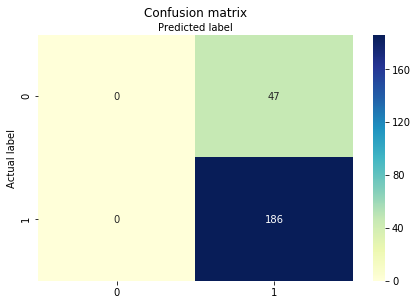

In [136]:
#@title
import sklearn
from sklearn import svm
from sklearn import metrics
from sklearn.svm import SVC

#preprocessing, take only top frequent operators
counts = Counter(Data["operator"])
labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

#indexes = np.arange(len(labels))

FilteredData=Data[Data["operator"].isin(labels[values>10])]

print("Value counts:" ,pd.Index(FilteredData.survivabilitychance).value_counts())

dummy=pd.get_dummies(FilteredData["operator"])

print("Dummy One HOT:")
print(dummy[-3:])
print("---------------")
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(dummy, FilteredData.survivabilitychance, test_size = 0.3,random_state=42)

clf = SVC(gamma=0.001,C=100,class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
clf.fit(X_train, Y_train)

#Predict the response for test dataset
Y_pred = clf.predict(X_test)
print(Y_pred.shape)


if(False):
 print("TEST:")
 print(Y_test[:1])
 print(Y_test.tolist()[1])
 print(len(Y_test))
 print("PREDICT:")
 print(list(Y_pred[:3]))
 print(len(list(Y_pred)))
 print("TEST LIST:")
 print(list(Y_test[:3]))
 print(len(list(Y_test))) 


cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred)
print("CONFUSION MATRIX:",cnf_matrix)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(list(Y_test), Y_pred))
# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(list(Y_test), Y_pred,average=None))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(list(Y_test), Y_pred,average=None))
# Model MRE
#print("MRE:",metrics.mean_squared_error(list(Y_test), Y_pred))


class_names=['High','Low'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.Text(0.5,257.44,'Predicted label')


In [27]:
counts = Counter(Data["operator"])
labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))




array(['Aeroflot', 'Indian Airlines', 'Air France',
       'Philippine Air Lines', 'United Air Lines',
       'Pan American World Airways', 'American Airlines', 'AVIANCA',
       'Garuda Indonesia Airlines', 'VASP', 'Merpati Nusantara Airlines',
       'Trans World Airlines', 'British European Airways',
       'Pakistan International Airlines', 'Cubana de Aviacion', 'Varig',
       'Eastern Air Lines', 'Ethiopian Airlines',
       'Turkish Airlines (THY)', 'China Airlines (Taiwan)',
       'Northwest Orient Airlines', 'Ceskoslovenske Aerolinie',
       'Cruzeiro', 'Aerolineas Argentinas', 'Linea Aeropostal Venezolana',
       'SATENA', 'Tarom', 'Air America', 'Air Vietnam (South Vietnam)',
       'Lloyd Aereo Boliviano', 'Flying Tiger Line', 'Burma Airways'],
      dtype='<U60')

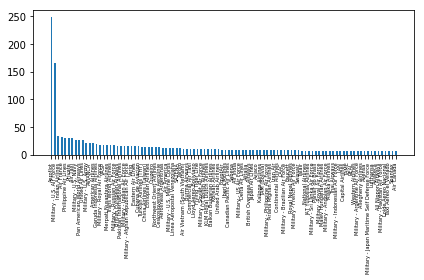

In [0]:
bar_width = 5
maxCountofOperators=100
plt.bar(indexes[:maxCountofOperators]*10, values[:maxCountofOperators],width=bar_width)
# add labels
plt.xticks(indexes[:maxCountofOperators]*10 , labels[:maxCountofOperators], rotation='vertical')
plt.tick_params(axis="x", labelsize=5, labelrotation=90, labelcolor="black") 
plt.tight_layout()
plt.savefig("operators",fontsize = 5,dpi=240,figsize=(100,10))
plt.show()


In [0]:
#print(labels[:maxCountofOperators])
NewData=Data[Data.operator.isin(labels[:maxCountofOperators])]
#NewData=NewData[NewData.survivability<3]
#print(NewData)

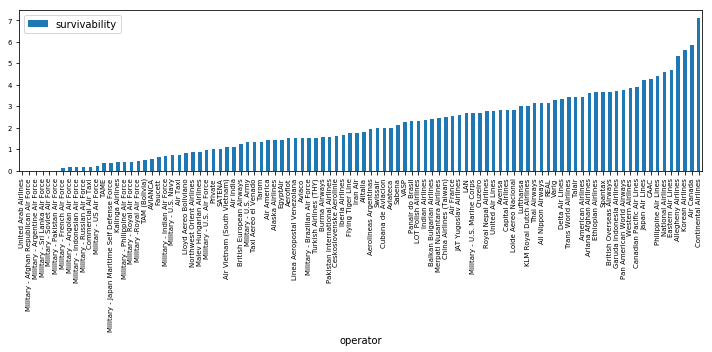

In [0]:
df = pd.DataFrame(NewData[['operator','survivability']])
df=df[~df.survivability.isin([np.inf,-np.inf])] #drop inf values because of zero denominator

dsurvive = pd.DataFrame(df.groupby('operator', as_index=False).mean())
dsurvive = dsurvive.sort_values('survivability', ascending=True)
dsurvive.plot(x='operator', kind='bar',fontsize=7,figsize=(10,5))
#print(dsurvive)
plt.tight_layout()
plt.savefig('survivability',fontsize = 7,dpi=240)

causes not avaiable: 4619
unindentified causes: 3142
engine failure 405
poor weather 385
stall 272
pilot error 174
on fire 116
turbulence 107
shot down 100
fuel exhaustion 57
electrical problem 47
structure failure 36
terrorism 11


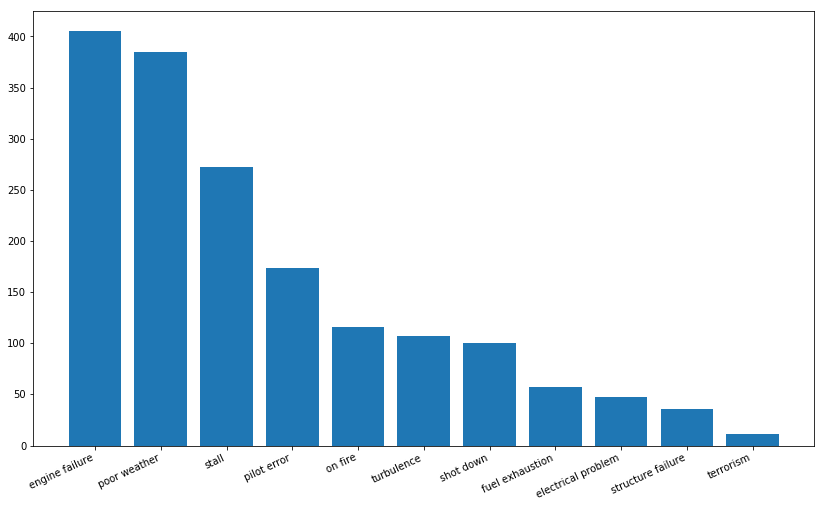

In [0]:
failures = {
    'pilot error': '(pilot|crew) (error|fatigue)',
    'engine failure': 'engine.*(fire|fail)',
    'structure failure': '(structural fail)|(fuel leak)|(langing gear)',
    'electrical problem': 'electrical',
    'poor weather': '((poor|bad).*(weather|visibility)|thunderstorm)',
    'stall': 'stall',
    'on fire': '(caught fire)|(caught on fire)',
    'turbulence': 'turbulence',
    'fuel exhaustion': '(out of fuel)|(fuel.*exhaust)',
    'terrorism': 'terrorist|terrorism',
    'shot down': 'shot down',
}

failure_counts = {'other':0}

for s in Data.summary.dropna():
    other = True
    for failure, exp in failures.items():
        if re.search(exp, s.lower()):
            other = False
            if failure in failure_counts:
                failure_counts[failure] += 1
            else:
                failure_counts[failure] = 1
    if other:
        failure_counts['other'] += 1

nan_counts = len(Data.summary.isnull())
print('causes not avaiable: %d' % nan_counts)
print('unindentified causes: %d' % failure_counts['other'])

del failure_counts['other']

sortedcauses = sorted(failure_counts.items(), key=operator.itemgetter(1), reverse=True)
for k, v in sortedcauses:
    print(k, v)

plt.figure(figsize=(14, 8))
x, y = zip(*sortedcauses)
plt.bar(x,y)
plt.xticks(rotation=25, horizontalalignment='right')
plt.show()

In [0]:
#nltk.download('stopwords')
#nltk.download('punkt')
#stoplist = set(stopwords.words('english') + list(punctuation))
#texts = Data.summary.str.lower()

#word_counts = Counter(word_tokenize('\n'.join(texts)))
#word_counts.most_common()

word_counts = Data.summary.apply(lambda x: pd.value_counts(x.lower().split(" "))).sum(axis = 0)
indSort = np.argsort(word_counts)[::-1]
word_counts[indSort]
Data[(Data.survivability < 3) & (Data.summary.str.contains("terror"))]

,date,time,location,operator,ac_type,passengers,crew,totalaboard,crew fatalities,passenger fatalities,total fatalities,ground fatalities,summary,survivability
352,11/04/1955,17:30,Near Great Natuna Island Sarawak,Air India,Lockheed 749A Constellation,11,8,19,8,11,19,0,An explosion occurred at 18 000 feet while ov...,0.0
2869,21/12/1988,19:03,Lockerbie Scotland,Pan American World Airways,Boeing B-747-121A,243,16,259,16,243,259,11,The airliner disappeared from radar shortly a...,0.0
3236,19/05/1993,15:04,Near Medellin Colombia,SAM Colombia,Boeing B-727-46,125,7,132,7,125,132,0,The plane hit Mt. Paramo Frontino at 12 300 f...,0.0
3481,17/07/1996,20:31,Near East Moriches New York,Trans World Airlines,Boeing B-747-131,212,18,230,18,212,230,0,While on a flight from New York to Paris Fran...,0.0
3897,22/02/2002,02:30,Near Dumaguete Philippines,Military - U.S. Army,MH-47 Chinook helicopter,4,6,10,6,4,10,0,A helicopter ferrying U.S. troops in a counte...,0.0
4114,14/08/2005,12:20,Near Grammatikos Greece,Helios Airways,Boeing 737-31S,115,6,121,6,115,121,0,While flying at FL340 towards Athens the crew...,0.0


Text(0, 0.5, 'chance of survival')

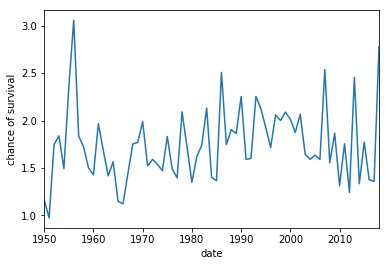

In [0]:
Data['date']=pd.to_datetime(Data['date'])
survivability_series=Data.groupby(Data['date'].dt.year)['survivability'].mean()
survivability_series=pd.Series(survivability_series,index=survivability_series.index)
survivability_series.dropna().plot()
plt.ylabel('chance of survival')

douglas      829
boeing       361
cessna       329
OTHER        318
antonov      290
lockheed     265
havilland    259
beech        170
ilyushin     141
piper        139
Name: plane_type, dtype: int64


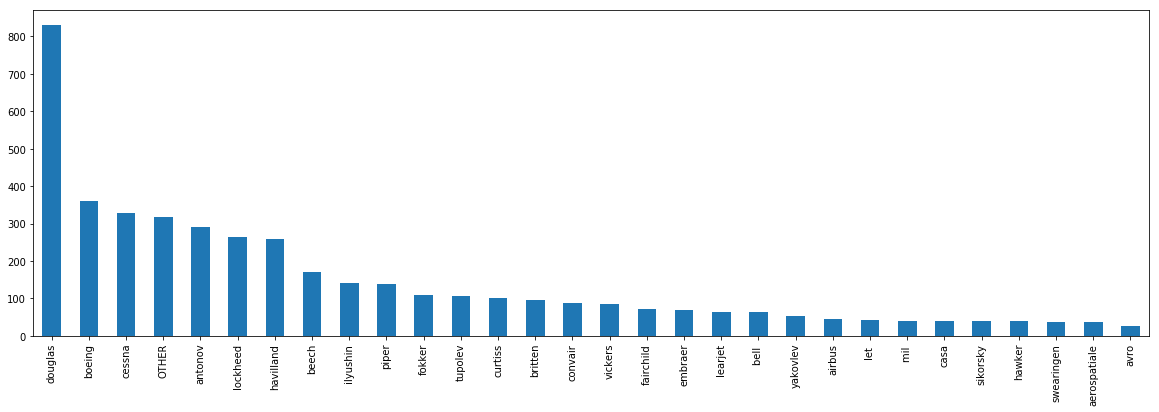

In [0]:
def type_extractor(x):
    plane_types = [
        'douglas', 'havilland', 'antonov', 'yakovlev', 'junkers', 'breguet', 'curtiss', 'embraer',
        'fokker', 'tupolev', 'lockheed', 'cessna', 'boeing', 'piper', 'britten', 'ilyushin', 'airship',
        'sikorsky', 'bristol', 'casa', 'convair', 'vickers', 'fairchild', 'consolidated', 'hawker', 'let ',
        'mil ', 'martin', 'airbus', 'bell ', 'learjet', 'avro', 'short', 'aerospatiale', 'beech', 'swearingen', 
        'british aerospace', 'canadair', 'farman ', 'aero commander', 'bac ',
        'dornier', 'ford', 'grumman', 'handley', 'latecoere', 'mi-', 'rockwell', 'sud'
    ]
    for name in plane_types:
        if name in x:
            return name
    return 'OTHER'

Data['ac_type'].fillna('not_known', inplace=True)
Data['ac_type'] = Data['ac_type'].str.lower()
Data['plane_type'] = Data['ac_type'].apply(type_extractor)

plt.figure(figsize=(20, 6))
Data['plane_type'].value_counts()[:30].plot('bar')
print(Data['plane_type'].value_counts()[:10])

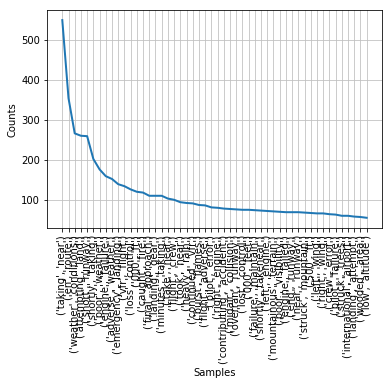

<Figure size 432x288 with 0 Axes>

In [0]:
from nltk import FreqDist
from nltk.corpus import stopwords
import string
from nltk import bigrams

def remove_punctuation(s):
    exclude = set(string.punctuation)
    s = ''.join([i for i in s if i not in exclude])
    return s

stop = stopwords.words('english')
stop.append('plane')
stop.append('crashed')
stop.append('aircraft')

t = Data[['summary','survivability']].dropna()
book = t['summary'].str.lower().apply(remove_punctuation).str.split().values.sum()
wrd = [w for w in book if w not in stop]

fdist = FreqDist(wrd)
#fdist.plot(50,cumulative = True)


bigrams = list(bigrams(wrd))
fdistBigram = FreqDist(bigrams)
fdistBigram.plot(50)
plt.tight_layout
plt.savefig('main_facotrs',fontsize = 7,dpi=70,figsize=(50, 12))